В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:
* order_datetime -  время заказа
* origin_longitude - долгота
* origin_latitude - широта
* m_order_eta - время до прибытия машины
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key - был ли назначен водитель
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.


В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину). 

#  **0.** Подготовка данных

Импортирую необходимые библиотеки, загружаю данные в pandas dataframe

In [452]:
## CODE HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data_orders = pd.read_csv('data_orders.csv')
data_offers = pd.read_csv('data_offers.csv')

In [453]:
data_orders.head()
#Изучаю данные

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [454]:
data_orders.info()
#Изучаю типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
order_datetime                   10716 non-null object
origin_longitude                 10716 non-null float64
origin_latitude                  10716 non-null float64
m_order_eta                      2814 non-null float64
order_gk                         10716 non-null int64
order_status_key                 10716 non-null int64
is_driver_assigned_key           10716 non-null int64
cancellations_time_in_seconds    7307 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.8+ KB


In [455]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


# **1.** Постройте распределение заказов по причинам неуспеха: отмены до и после назначения водителя, режекты

In [456]:
## CODE HERE
data_orders['order_status_key'].value_counts()
# проверяю данные на предмет уникальности, есть ли другие значения, кроме указанных выше.

4    7307
9    3409
Name: order_status_key, dtype: int64

In [457]:
data_orders['is_driver_assigned_key'].value_counts()
# проверяю данные на предмет уникальности, есть ли другие значения, кроме указанных выше.

0    7902
1    2814
Name: is_driver_assigned_key, dtype: int64

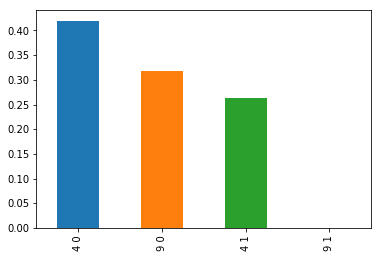

In [458]:

combined = data_orders['order_status_key'].astype('str')+' '+ data_orders['is_driver_assigned_key'].astype('str')
combined.value_counts(normalize = True).plot.bar()

#

* Похоже, что большинcтво причин отказов - отмены клиентом без назначения водителя. Возможно, клиенты заказывали такси по ошибке или передумывали. На втором месте - отмены системой без назначения водителя. Очевидно, что система не будет отменять заказ, если водитель уже назначен, поэтому  колонка, где идёт отмена системой и водитель назначен (9-1) на последнем месте.

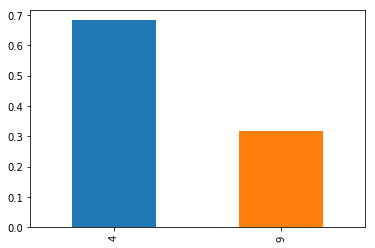

In [459]:
data_orders['order_status_key'].value_counts(normalize = True).plot.bar()

* Мы видим, что большинство отмены заказов сделали клиенты

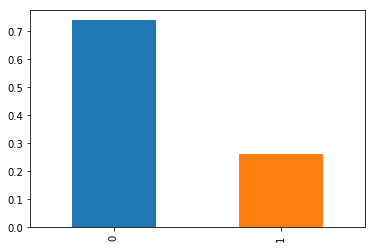

In [460]:
data_orders['is_driver_assigned_key'].value_counts(normalize = True).plot.bar()

* Также мы видим, что большинство  водителей не было назначено системой.

#  **2.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

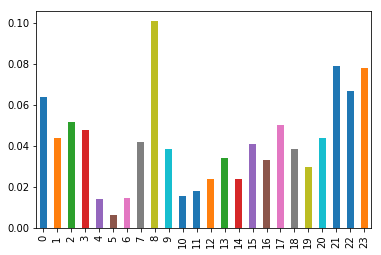

In [461]:
## CODE HERE
order_datetime_dt = pd.to_datetime(data_orders['order_datetime'])
order_datetime_dt = pd.Index(order_datetime_dt).hour
data_orders['order_datetime_dt'] = order_datetime_dt
data_orders['order_datetime_dt'].value_counts(normalize = True).sort_index(ascending=True).plot.bar()

В какие часы фейлов больше всего? Чем это можно объяснить?

* Мы видим, что пиковые часы отказов - в 8 часов, а также ближе к ночи с 9 вечера. Это связано, прежде всего, с общим количеством заказов. Утром люди едут на работу, берут такси, чтобы успеть на работу к 9 утра, вечером люди возвращаются с работы, из других заведений и берут такси. Соответственно, там, где пиковая нагрузка, там и пиковые отказы

#  **3**. Постройте графики среднего времени до отмены (cancellations_time_in_seconds) с водителем и без, по часам. Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

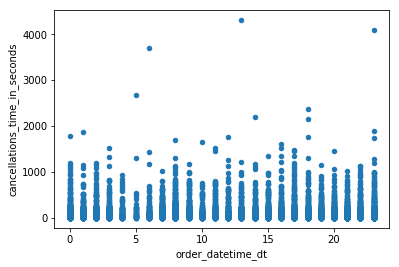

In [462]:
## CODE HERE
data_orders.plot(x = 'order_datetime_dt',y = 'cancellations_time_in_seconds',kind='scatter')
#Проверяю, есть ли выбросы данных. Похоже, что если сделать отсечку в 2000 секунд, большинство выбросов можно будет отсечь

In [463]:
data_orders['cancellations_time_in_seconds'][data_orders['cancellations_time_in_seconds']>2000].value_counts()
#Считаю количество данных, которые отсекутся. 7 записей не повлияют на общие выводы. Можно смело отсекать данные.

2376.0    1
3697.0    1
4303.0    1
2680.0    1
2155.0    1
2190.0    1
4097.0    1
Name: cancellations_time_in_seconds, dtype: int64

In [464]:
data_orders['cancellations_time_in_seconds'] = data_orders['cancellations_time_in_seconds'][data_orders['cancellations_time_in_seconds']<2000]
data_orders = data_orders.dropna()


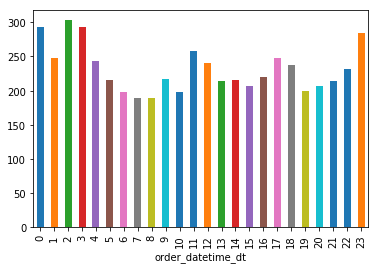

In [465]:
gr_bar = data_orders.groupby('order_datetime_dt')

gr_bar['cancellations_time_in_seconds'].agg(np.mean).plot.bar()


* Похоже, что люди чаще всего дольше готовы ждать ночью и рано утром, полагаю, это связано с тем, что если человек едет ночью, у него есть приоритетные задачи, которыми лучше не рисковать, рассматривая другие варианты, да и транспорта меньше ходит ночью. Поездку в аэропорт без такси тяжело ночью провести.

#  **4.** Постройте распределение среднего ЕТА по часам. Чем можно объяснить такой вид графика?

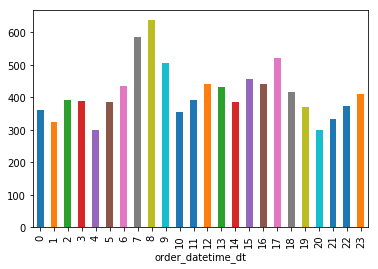

In [466]:
gr_bar['m_order_eta'].agg(np.mean).plot.bar()

## CODE HERE

* Пиковые значения связаны с пробками на дорогах. Пиковая нагрузка утром, люди спешат на работу, такси стоит в пробках, движение затруднено. Это повторяется в 5 вечера, когда люди уезжают с работы и попадают опять в пробки.

#  5. Колонка drivers_offered - показывает сколько водителей увидели заказ и могли его принять. Постройте часовую разбивку среднего количества водителей которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

In [467]:
## CODE HERE
gr_offers = data_offers.groupby('order_gk')
data = gr_offers['offer_id'].agg(np.count_nonzero)

data_orders = data_orders.join(data, on = ['order_gk'], how = 'left')

In [468]:
data_orders = data_orders.rename(index=str, columns={"offer_id": "drivers_offered"})


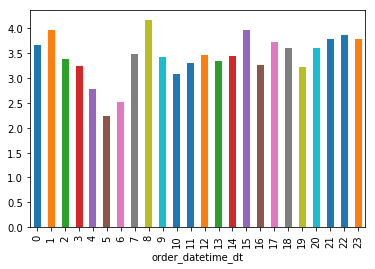

In [469]:
gr_bar = data_orders.groupby('order_datetime_dt')
gr_bar['drivers_offered'].agg(np.mean).plot.bar()

* Загрузка водителей, в целом, равномерна в течение дня и вечером и падает ночью, т.к. ночных заказов меньше.

**6*.** Гексаконы.
Воспользовавшись пакетами h3 и folium, посчитайте, сколько гексагонов размера 8 (https://uber.github.io/h3/#/documentation/core-library/resolution-table) содержат 80% всех заказов из исходного датасета и визуализируйте гексагон с наибольшим количеством фейлов на карте.

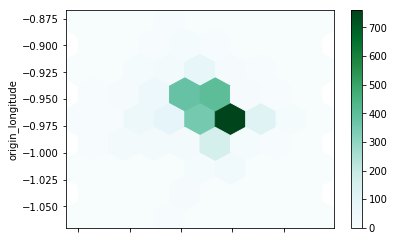

In [471]:
fig = plt.figure
plt.xticks
data_orders.plot.hexbin(x='origin_latitude', y='origin_longitude', gridsize=8, legend = True)
plt.xticks(rotation = 90)
plt.show()


* Ответ - 5 гексагонов. Пик приходится на центр города

In [475]:
import folium
from h3_py_master import h3

m = folium.Map( zoom_start = 8)
location = data_orders[['origin_latitude','origin_longitude']]

location

folium.vector_layers.Polygon(location, popup=None, tooltip=None).add_to(m)
folium.features.RegularPolygonMarker([51.45,-0.975], number_of_sides=6, rotation=0, radius=8, popup=None, tooltip=None,color='green').add_to(m)

m
